In [6]:
from train.training_session_v2 import load_training_session
import multiprocessing
import torch

device = "cuda"

session = load_training_session(
    save_path="saves/phase3/objectives/baseline_gwilliams_no_timestamps/epoch_49",
    studies={"gwilliams2023": "audiotext"},
    data_path="data",
    cache_name="/home/ubuntu/cache",
)

dataloader = session.get_dataloader(buffer_size=1, num_workers=1, max_cache_size=100, tokenize=True, add_timestamps=True)

# Unseen both
# recording = session.studies["gwilliams2023"].recordings[19][0][0]

# Seen
# recording = session.studies["gwilliams2023"].recordings[15][0][1]

# Unseen task
recording = session.studies["gwilliams2023"].recordings[18][0][0]

# Unseen subject
# recording = session.studies["gwilliams2023"].recordings[19][0][1]

print(
    f"Showing recording: {recording.study_name}_{recording.subject_id}_{recording.task_id}"
)

dataloader.start_fetching(recordings=[recording])
batch = dataloader.get_recording()
(
    brain, 
    audio, 
    transcripts,
    transcript_attn_masks,
    recording,
) = (
    batch.brain_segments["all"].to(device),
    batch.audio_segments.to(device),
    batch.transcript.to(device),
    batch.transcript_attention_masks.to(device),
    batch.recording,
)


conditions = {
    "study": f"{recording.study_name}",
    "subject": f"{recording.study_name}_{recording.subject_id}",
}
session.model.to(device).eval()

# with torch.no_grad():
#     (
#         x,  # [B, C, T]
#         quantizer_metrics,
#         channel_weights,
#         hidden_outputs,
#         encoder_hidden_states,  # L * [B, T, D]
#     ) = session.model(
#         x=[brain],
#         recording=[recording],
#         conditions=[conditions],
#         mel=[audio],
#         train=False,
#         return_hidden_outputs=False,
#     )

pad_len = 3000 - audio.size(2)
encoder_attention_mask = torch.zeros(
    audio.size(0), 3000, device=device
)  # [B, T]
encoder_attention_mask[:, : audio.size(2)] = 1

(
    token_ids,  # [B, T]
    x,  # [B, 80, T']
    quantizer_metrics,
    channel_weights,
    hidden_outputs,
) = session.model.generate(
    x=brain,
    recording=recording,
    conditions=conditions,
    mel=None,
    max_new_tokens=int(16 * session.config.window_size),
    attention_mask=encoder_attention_mask,
    return_hidden_outputs=False,
)

dataloader.stop()

Loading Gwilliams2023 with batch type audiotext
Data partitioned on studies ['gwilliams2023'].
Train: 135, Unseen Task: 45, Unseen Subject: 12, Unseen Both: 4.

RNNEncoder initialized as conformer with 4 layers, 256 d_model, 4 nhead
	Embedding: sinusoidal, params: 6075392
SimpleConv initialized with 8927984 parameters, cond: ['study', 'subject']
Merger False, merger channels 0
ConvBlocks: 4, hidden_dim: 256, params 2626048


Found 64 target modules for AdaLora: ['model.encoder.layers.0.self_attn.k_proj', 'model.encoder.layers.0.self_attn.v_proj', 'model.encoder.layers.0.self_attn.q_proj', 'model.encoder.layers.0.self_attn.out_proj', 'model.encoder.layers.0.fc1', 'model.encoder.layers.0.fc2', 'model.encoder.layers.1.self_attn.k_proj', 'model.encoder.layers.1.self_attn.v_proj', 'model.encoder.layers.1.self_attn.q_proj', 'model.encoder.layers.1.self_attn.out_proj', 'model.encoder.layers.1.fc1', 'model.encoder.layers.1.fc2', 'model.encoder.layers.2.self_attn.k_proj', 'model.encoder.layers.2.self_attn.v_proj', 'model.encoder.layers.2.self_attn.q_proj', 'model.encoder.layers.2.self_attn.out_proj', 'model.encoder.layers.2.fc1', 'model.encoder.layers.2.fc2', 'model.encoder.layers.3.self_attn.k_proj', 'model.encoder.layers.3.self_attn.v_proj', 'model.encoder.layers.3.self_attn.q_proj', 'model.encoder.layers.3.self_attn.out_proj', 'model.encoder.layers.3.fc1', 'model.encoder.layers.3.fc2', 'model.decoder.layers.0.se

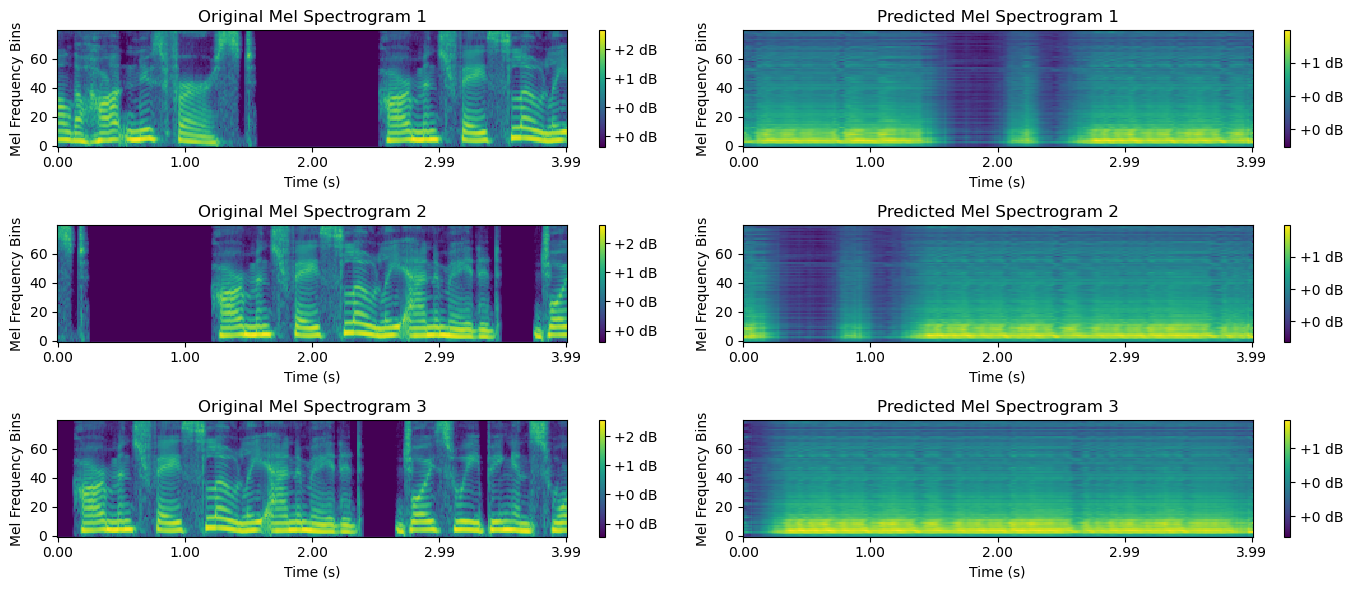

In [7]:
from utils.plot_mel import plot_mel_spectrogram

plot_mel_spectrogram(
    x=audio[15:18].cpu().numpy(),
    max_plots=3,
    x_pred=x[15:18].cpu().numpy(),
)

In [3]:
audio[17][:, 380:]

tensor([[0.3715, 0.5808, 0.5865,  ..., 0.4569, 0.4331, 0.6307],
        [0.3618, 0.6045, 0.6429,  ..., 0.6286, 0.5133, 0.8007],
        [0.4400, 0.4438, 0.8026,  ..., 0.9164, 0.8684, 0.9572],
        ...,
        [1.1499, 1.1016, 0.9648,  ..., 0.3291, 0.3433, 0.2700],
        [0.9576, 1.0452, 0.9274,  ..., 0.4003, 0.3982, 0.3692],
        [0.9312, 0.8764, 0.8008,  ..., 0.2576, 0.2439, 0.2492]],
       device='cuda:0')

In [9]:
audio.max(), audio.min(), audio.mean(), audio.std(), x.max(), x.min(), x.mean(), x.std()

(tensor(1.8745, device='cuda:0'),
 tensor(-0.2498, device='cuda:0'),
 tensor(0.4936, device='cuda:0'),
 tensor(0.4758, device='cuda:0'),
 tensor(1.6027, device='cuda:0'),
 tensor(-0.6130, device='cuda:0'),
 tensor(0.5684, device='cuda:0'),
 tensor(0.2774, device='cuda:0'))

In [10]:
decoded_output = session.tokenizer.batch_decode(
    sequences=token_ids[15:25],
    skip_special_tokens=True,
    decode_with_timestamps=False,
    clean_up_tokenization_spaces=True,
)
# Remove extra spaces
decoded_output = [
    " ".join([w for w in sentence.split(" ") if w]) for sentence in decoded_output
]
decoded_output

['the the',
 'the the',
 'I must admit this seems',
 'the the',
 'the the',
 'the the',
 'the the',
 'the the',
 'the the',
 'the the']

In [11]:
decoded_label = session.tokenizer.batch_decode(
    sequences=transcripts[15:25],
    skip_special_tokens=True,
    decode_with_timestamps=False,
    clean_up_tokenization_spaces=True,
)
decoded_label = [
    " ".join([w for w in sentence.split(" ") if w]) for sentence in decoded_label
]
decoded_label

['the hot news first face',
 'face slowly animated',
 'face slowly animated joy sweeping in',
 'animated joy sweeping in to replace stern',
 'in to replace stern concentration',
 'concentration says the',
 'says the',
 'the',
 'planet tiny',
 'planet tiny away']

In [ ]:
for name, param in session.model.named_parameters():
    print(name, param.size())

brain_module.initial_batch_norm.weight torch.Size([208])
brain_module.initial_batch_norm.bias torch.Size([208])
brain_module.initial_linear.0.weight torch.Size([256, 208, 1])
brain_module.initial_linear.0.bias torch.Size([256])
brain_module.encoders.sequence.0.1.weight torch.Size([256, 256, 5])
brain_module.encoders.sequence.0.1.bias torch.Size([256])
brain_module.encoders.sequence.0.2.weight torch.Size([256])
brain_module.encoders.sequence.0.2.bias torch.Size([256])
brain_module.encoders.sequence.1.0.weight torch.Size([256, 256, 5])
brain_module.encoders.sequence.1.0.bias torch.Size([256])
brain_module.encoders.sequence.1.1.weight torch.Size([256])
brain_module.encoders.sequence.1.1.bias torch.Size([256])
brain_module.encoders.sequence.2.0.weight torch.Size([256, 256, 3])
brain_module.encoders.sequence.2.0.bias torch.Size([256])
brain_module.encoders.sequence.2.1.weight torch.Size([256])
brain_module.encoders.sequence.2.1.bias torch.Size([256])
brain_module.encoders.sequence.3.0.weigh

: 